In [1]:
from  pykrx import stock
import pandas   as pd
from datetime import datetime
import mariadb
import ta

In [2]:
def get_connection() :
    """
    마리아DB 접속 Connection 을 획득한다.
    """
    conn = None
    try:
        conn = mariadb.connect(
            user="root",
            password="123",
            host="localhost",
            port=3306,
            database="home"
        )
    except mariadb.Error as e:
        print(f"Error connecting to MariaDB Platform: {e}")
    finally :
        return conn

In [3]:
sql = """
    SELECT a.code as 코드
          ,b.name as 종목명
          ,a.date as 날짜
          ,a.close as  종가
          ,c.ts + c.sm + c.yk  AS 기관
          ,c.fr AS 외국인
          
    FROM   daily_price   a

    JOIN   company_info b
            ON  A.CODE = B.CODE

    JOIN   daily_agent  c 
            ON  a.code = c.code
            AND a.date = c.date
            
    WHERE  a.date >= date_add(now(), INTERVAL -4 MONTH)  
"""

In [5]:
conn = get_connection()
df  = pd.read_sql(sql, conn)
df['기관누적'] = df['기관'].cumsum()
df['외국인누적'] = df['외국인'].cumsum()
df_corr = df[["코드","종목명","날짜","종가","기관누적","외국인누적"]]
df_corr = df_corr.dropna()
df_corr_기관 = df_corr.groupby(["코드","종목명"]).apply(lambda p : p['종가'].corr(p['기관누적'])).reset_index()
df_corr_외인 = df_corr.groupby(["코드","종목명"]).apply(lambda p : p['종가'].corr(p['외국인누적'])).reset_index()
df_corr_기관.rename(columns={0:"Corr기관"},inplace=True)
df_corr_외인.rename(columns={0:"Corr외인"},inplace=True)
df_corr = df_corr.merge(df_corr_기관, on=["코드","종목명"],how="left")
df_corr = df_corr.merge(df_corr_외인, on=["코드","종목명"],how="left")
df_corr.dropna(inplace=True)
df_corr['MA5_기관누적']=ta.trend.SMAIndicator(close=df_corr["기관누적"],window=5).sma_indicator()
df_corr['MA5_외인누적']=ta.trend.SMAIndicator(close=df_corr["외국인누적"],window=5).sma_indicator()
df_corr = df_corr[df_corr["날짜"]=="20230810"]
print(f"correlation coefficient dataframe created!!! {len(df_corr)} 건")
result = df_corr.values.tolist()

C:\Users\swkao\AppData\Local\Temp\ipykernel_13424\3842287851.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df  = pd.read_sql(sql, conn)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


correlation coefficient dataframe created!!! 2450 건


In [7]:
from openpyxl import load_workbook

wb = load_workbook("Major.xlsx")
del  wb["R"]
wb.create_sheet("R")
ws = wb["R"]
ws.append(["코드","종목명","날짜","종가","기관누적","외국인누적","상관계수기관","상관계수외인","기관누적MA5","외인누적MA5"])
for r in result :
    ws.append(r)

wb.save("Major.xlsx")    

In [11]:
df_corr = df_corr.merge(df_corr_기관, on=["코드","종목명"],how="left")
df_corr = df_corr.merge(df_corr_외인, on=["코드","종목명"],how="left")
df_corr.dropna(inplace=True)
df_corr['MA5_기관누적']=ta.trend.SMAIndicator(close=df_corr["기관누적"],window=5).sma_indicator()
df_corr['MA5_외인누적']=ta.trend.SMAIndicator(close=df_corr["외국인누적"],window=5).sma_indicator()
df_corr = df_corr[ (df_corr["날짜"]== '20230809') & (df_corr["코드"] == "000020") ]

In [12]:
df_corr[(df_corr["날짜"]== '20230809') & (df_corr["코드"] == "000020")].values.tolist()[0]

['000020',
 '동화약품',
 '20230809',
 10520,
 2103092480,
 3388798760,
 0.9158729315965687,
 0.5817312559627621,
 2119724750.0,
 2704455544.0]

In [2]:
df_corr.info()

NameError: name 'df_corr' is not defined

In [13]:
len(df_corr)

1

In [12]:
list1 = df_corr_기관[df_corr_기관['Corr기관'] > 0.8].values.tolist()

389

In [ ]:
list1
# [['000020', '동화약품', 0.9158729315965687],
#  ['000080', '하이트진로', 0.8805805269656648],
#  ['000100', '유한양행', 0.8737403974055673],
#  ['000105', '유한양행우', 0.935794617660753],
#  ['000120', 'CJ대한통운', 0.8804940400100879],

In [15]:
from  pykrx import stock
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import pandas   as pd
from datetime import datetime
import ta
import seaborn as sns

In [16]:
# matplotlib 에서 한글이 깨진다. 한글폰트 세팅이 필요함
# 한글 폰트 사용을 위해서 세팅
font_path = r"C:\Windows\Fonts\H2GTRM.TTF"
# font_path = r"C:\Users\swkao\AppData\Local\Microsoft\Windows\Fonts\D2CodingBold-Ver1.3.2-20180524-ligature.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [27]:
len(df.index)

78

C:\Users\swkao\AppData\Local\Temp\ipykernel_11344\4127658697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA5']=ta.trend.SMAIndicator(close=df["기관누적"],window=5).sma_indicator()
C:\Users\swkao\AppData\Local\Temp\ipykernel_11344\4127658697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


<Axes: title={'center': '아비코전자'}, xlabel='날짜', ylabel='기관누적'>

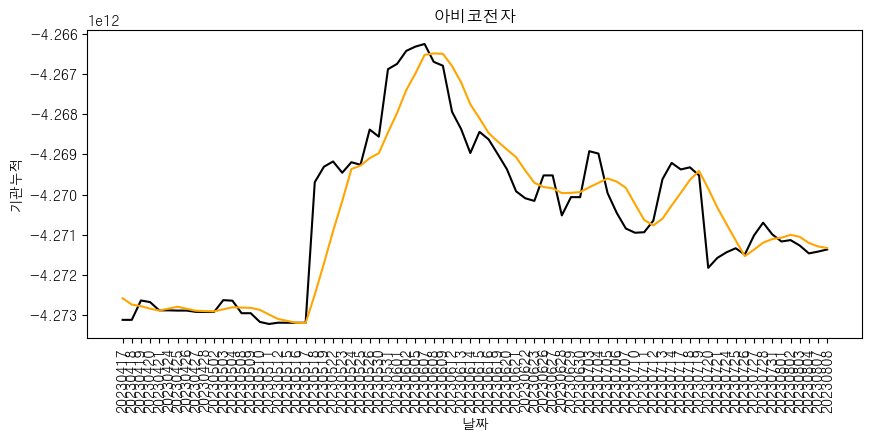

In [33]:
df = df_corr[df_corr['코드']=='036010']
df['MA5']=ta.trend.SMAIndicator(close=df["기관누적"],window=5).sma_indicator()
df.dropna(inplace=True)

plt.figure(figsize=(10,4))
# plt.locator_params(axis='x', nbins=len(df.index)/2)
plt.xticks(rotation=90)
sns.lineplot(x="날짜", y="기관누적", data=df,color='black').set_title('아비코전자')
sns.lineplot(x="날짜", y="MA5", data=df,color='orange')

In [56]:
df = stock.get_market_ohlcv("20230808")
df.head()

,시가,고가,저가,종가,거래량,거래대금,등락률
티커,,,,,,,
095570,4340,4380,4315,4345,52701,228838520,0.12
006840,19140,19300,18740,18960,7259,137487650,-0.21
027410,3595,3640,3575,3600,56640,203639275,0.14
282330,173400,173400,170000,171600,27146,4661475100,0.76
138930,6830,6840,6760,6770,701209,4761708990,0.30


In [60]:
df = stock.get_market_trading_value_by_date('20230802', '20230802', '033180', detail=True)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 13 elements

In [20]:
df = stock.get_market_trading_value_by_investor('20230802', '20230803', '200670')

In [25]:
df

,금융투자,보험,투신,사모,은행,기타금융,연기금,기타법인,개인,외국인,기타외국인,전체
날짜,,,,,,,,,,,,
2023-08-02,-2353200,-38036750,-21834400,25134400,0,0,219580600,-5780750,-371843100,208176200,-13043000,0
2023-08-03,180342250,2992950,2335050,-52197050,-68669550,50,115029950,32049650,-1550838300,1371441750,-32486750,0
2023-08-04,387043200,-179864100,-17274250,1494351050,92181600,10626000,331378600,-126411450,-2825532400,846069950,-12568200,0


In [73]:
import pandas   as pd
from  pykrx import stock
import time

In [67]:
base_date = "20230804"

def  get_tickers(base_date) :
    """
        get_market_ticker_list 로 종목리스트를 작성하여 리턴한다.
    """
    tickers=[]
    tickers_list = stock.get_market_ticker_list(base_date,market='KOSPI')
    for ticker in tickers_list :
        tickers.append((ticker,stock.get_market_ticker_name(ticker),'KOSPI'))

    tickers_list = stock.get_market_ticker_list(base_date,market='KOSDAQ')
    for ticker in tickers_list :
        tickers.append((ticker,stock.get_market_ticker_name(ticker),'KOSDAQ'))
    
    return tickers


In [70]:
tickers = get_tickers(base_date)

In [76]:
for ticker in tickers :
    try :
        time.sleep(1)
        df_investor = stock.get_market_trading_value_by_investor(base_date, base_date, ticker[0])
        df_cap = stock.get_market_cap(base_date)
        major_cap = df_cap[df_cap.index == ticker[0]]['시가총액'][0]
        major_investor = df_investor[df_investor.index.isin(["투신","사모","연기금 등","외국인"])]["순매수"].sum()
        purchase_size = major_investor/major_cap * 100
    except ValueError :
        print(f"[df fetch :{base_date=} {ticker[0]=} ] ValueError Continue...")
        continue

    if df_investor.empty or df_cap.empty:
        continue    
    if  purchase_size > 0.1 :
        print(f'{ticker[1]}({ticker[0]}) : {purchase_size:.2f}')



CJ대한통운(000120) : 0.46


KeyboardInterrupt: 

In [84]:
df_investor = stock.get_market_trading_value_by_investor("20230804", "20230804", '383220')
df_investor

,매도,매수,순매수
투자자구분,,,
금융투자,849522800,869596400,20073600
보험,23069400,1205751400,1182682000
투신,24916700,2724229400,2699312700
사모,87735500,491510700,403775200
은행,0,28042800,28042800
기타금융,11017400,0,-11017400
연기금 등,432979400,2977873500,2544894100
기관합계,1429241200,8297004200,6867763000
기타법인,651765100,241531500,-410233600


In [87]:
major_investor = df_investor[df_investor.index.isin(["투신","사모","연기금 등","외국인"])]["순매수"].sum()
print(major_investor)

5412263000


In [18]:
import pandas   as pd
from  pykrx import stock

df_cap = stock.get_market_cap("20230811")
df_cap = df_cap.reset_index()
df_cap =  df_cap[["티커","시가총액"]]
df_cap
# major_cap = df_cap[df_cap.index == '383220']['시가총액'][0]
# print(major_cap)

,티커,시가총액
0,005930,402960322125000
1,373220,127998000000000
2,000660,83938672684500
3,207940,57010374000000
4,005490,48797599710000
...,...,...
2741,318660,2991420390
2742,288490,2670290000
2743,245450,2526356040
2744,322190,1338779550


In [83]:
8734152300 / 1882018380000 * 100

0.46408432525510196

In [1]:
from  pykrx import stock
import pandas   as pd
from datetime import datetime
import mariadb
import time

In [71]:
df = stock.get_market_trading_value_by_date('20230807', '20230807', '383220', detail=True)
df.head(5)

,금융투자,보험,투신,사모,은행,기타금융,연기금,기타법인,개인,외국인,기타외국인,전체
날짜,,,,,,,,,,,,
2023-08-07,-149307700,654271500,338199000,238680100,0,0,805824800,259490900,679293500,-2852270100,25818000,0


In [72]:
for sidx,srow in df.iterrows() :
    print(*srow)

-149307700 654271500 338199000 238680100 0 0 805824800 259490900 679293500 -2852270100 25818000 0


In [69]:
df_investor = stock.get_market_trading_value_by_investor('20230807', '20230807', '383220').T
df_investor = df_investor[df_investor.index.isin(["순매수"])]
df_investor["날짜"] = '20230807'
df_investor = df_investor.set_index("날짜")
df_investor = df_investor.drop(columns=["기관합계"])
df_investor

투자자구분,금융투자,보험,투신,사모,은행,기타금융,연기금 등,기타법인,개인,외국인,기타외국인,전체
날짜,,,,,,,,,,,,
20230807,-149307700,654271500,338199000,238680100,0,0,805824800,259490900,679293500,-2852270100,25818000,0


In [70]:
for sidx,srow in df.iterrows() :
    print(*srow)

-149307700 654271500 338199000 238680100 0 0 805824800 259490900 679293500 -2852270100 25818000 0


In [30]:
df = pd.read_excel("Major.xlsx", sheet_name="R")
df.dropna(inplace=True)
tickers = df[df["시총"] > 100_000_000_000][["코드","종목명","주도주체","시총"]].values.tolist()
# tickers = df[df["시총"] > 100_000_000_000]["코드","종목명","주도주체","시총"].values.tolist()
tickers


[['000020', '동화약품', '기관', 296352896700],
 ['000050', '경방', '외인', 259074301500],
 ['000080', '하이트진로', '기관', 1434232344950],
 ['000100', '유한양행', '기관', 5855193394800],
 ['000120', 'CJ대한통운', '기관', 1836393692000],
 ['000210', 'DL', '기관', 842426536800],
 ['000370', '한화손해보험', '기관', 461118714250],
 ['000540', '흥국화재', '외인', 199794625950],
 ['000660', 'SK하이닉스', '외인', 86268280252500],
 ['000700', '유수홀딩스', '기관', 151042509600],
 ['000720', '현대건설', '기관', 3964265234000],
 ['000815', '삼성화재우', '외인', 561472800000],
 ['000970', '한국주철관', '외인', 157323450000],
 ['001045', 'CJ우', '기관', 101936057300],
 ['001120', 'LX인터내셔널', '기관', 1375980000000],
 ['001130', '대한제분', '외인', 221390000000],
 ['001200', '유진투자증권', '외인', 367608056310],
 ['001450', '현대해상', '기관', 2704350000000],
 ['001460', 'BYC', '외인', 266398297500],
 ['001500', '현대차증권', '기관', 264799892700],
 ['001510', 'SK증권', '외인', 302457709440],
 ['001520', '동양', '외인', 242264323945],
 ['001570', '금양', '기관', 8335985313200],
 ['001680', '대상', '외인', 619160206750],
 ['